## Tutorial: cell type deconvolution for ISSAAC dataset (multi-omics dataset: spatial transcriptomics, scRNA-seq and scATAC-seq)

In [1]:
import torch
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# from .util import permutation
import os
import random
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import sys
sys.path.insert(1, '/home/nas2/biod/myy/project/CLPLS_package')
from CLPLS.util import *
from CLPLS.process import process_sc, process_st, process_activity
from CLPLS.train import train,PLSR,train_multiomics

In [2]:
random_seed = 11
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

#read data
st_adata = sc.read_h5ad('/home/nas2/biod/myy/project/CLPLS_package/data/ISSAAC/adata_st.h5ad')
sadj, graph_neigh, label_CSL = process_st(st_adata)

sc_adata = sc.read_h5ad('/home/nas2/biod/myy/project/CLPLS_package/data/ISSAAC/adata_rna.h5ad')
ctype_lab_rna, fadj = process_sc(sc_adata, "Annotation")

activity_adata = sc.read_h5ad("/home/nas2/biod/myy/project/CLPLS_package/data/ISSAAC/adata_activity.h5ad")
ctype_lab_activity, activity_adj = process_activity(activity_adata, "ATAC_Cluster")

embedding_st, embedding_sc, embedding_activity = train_multiomics(rna_dim_input=319, activity_dim_input=378, dim_input=624,hidden_channels=256,dim_output=50,activity_adata=activity_adata,st_adata=st_adata,graph_neigh=graph_neigh,spatial_graph=sadj,sc_adata=sc_adata,snn=fadj,activity_adj=activity_adj,ctype_lab_rna=ctype_lab_rna,ctype_lab_activity=ctype_lab_activity,label_CSL=label_CSL,epochs=250,beta=0.1,theta=1,alpha=1)

Graph with 1072 nodes and 3100 edges
[0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 4 5 5]
[ 295  592  638 ... 1030 1049 1061]
tensor([[ 295,  592,  638,  ...,  564,  760,  812],
        [   0,    0,    0,  ..., 1071, 1071, 1071]])
tensor([[   0,    0,    0,  ..., 4280, 4280, 4280],
        [ 137,  727,  889,  ..., 3838, 4011, 4013]])
Begin to train ST data...


100%|██████████| 250/250 [00:31<00:00,  7.86it/s]

Optimization finished for ST data!
Training complete!
Embedding is saved 


In [3]:
df_projection = PLSR(sc_adata, st_adata, embedding_sc,embedding_st,component=10,label='Annotation')

/home/moyuanyuan/anaconda3/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


[<Axes: title={'center': 'R0 Ex-L2/3 IT'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'R2 Ex-L4/5 IT'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'R5 Ex-L5 PT'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'R6 Ex-L6 CT'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'R7 Ex-L6 IT Bmp3'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'R9 Ex-L6b'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'R21 Oligo'}, xlabel='spatial1', ylabel='spatial2'>]

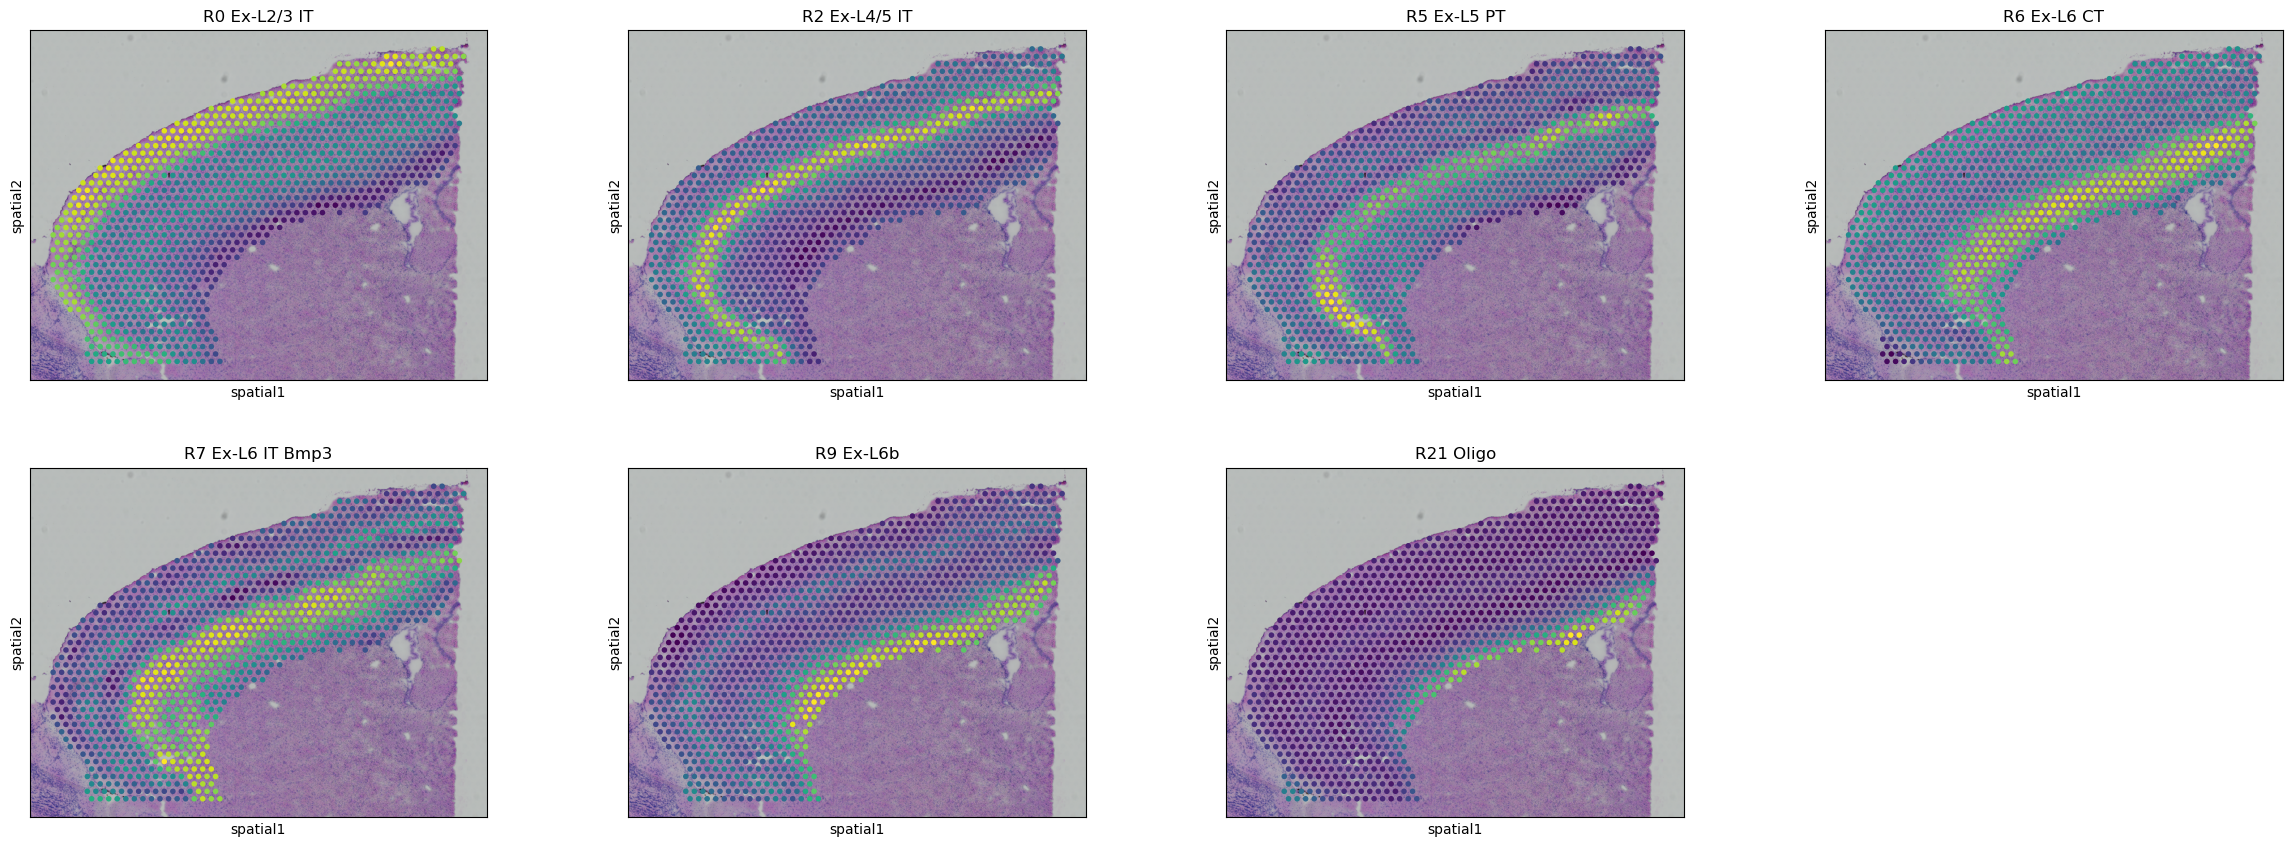

In [5]:
adata_st1 = st_adata.copy()
for i in range(7):
    adata_st1.obs[df_projection.columns.values[i]] = df_projection.values[:,i]
sc.pl.spatial(adata_st1,img_key="hires", color=['R0 Ex-L2/3 IT','R2 Ex-L4/5 IT','R5 Ex-L5 PT','R6 Ex-L6 CT','R7 Ex-L6 IT Bmp3','R9 Ex-L6b','R21 Oligo'],colorbar_loc=None,show=False)